This code belongs to SAURAV KUMAR(21D070063). In these file of code, i have written solution of problem 3. I have taken help from geeks for geeks youtube channel and its official website. link: https://www.geeksforgeeks.org/support-vector-regression-svr-using-linear-and-non-linear-kernels-in-scikit-learn/,
also from stachexchange, datacamp, tuitorialspoint.

part (a):
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html 

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

Load Data

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images

In [3]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

Visualizing the model predictions

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the ConvNet

In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=2)

Epoch 0/1
----------
train Loss: 0.2579 Acc: 0.8770
val Loss: 0.2642 Acc: 0.9020

Epoch 1/1
----------
train Loss: 0.2824 Acc: 0.9016
val Loss: 0.2425 Acc: 0.9085

Training complete in 1m 15s
Best val Acc: 0.908497


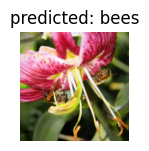

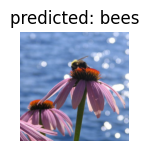

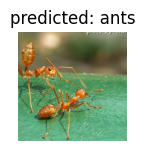

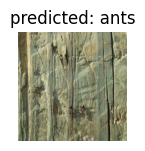

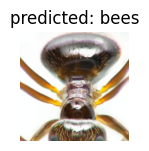

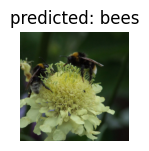

In [ ]:
visualize_model(model_ft)

ConvNet as fixed feature extractor

In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=2)

Epoch 0/1
----------
train Loss: 0.6531 Acc: 0.5984
val Loss: 0.2326 Acc: 0.9085

Epoch 1/1
----------
train Loss: 0.3905 Acc: 0.8197
val Loss: 0.2120 Acc: 0.9085

Training complete in 0m 45s
Best val Acc: 0.908497


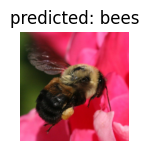

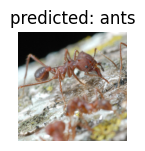

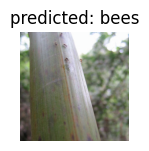

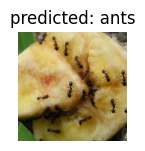

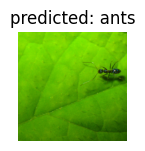

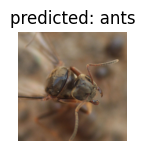

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Inference on custom models:

In [ ]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

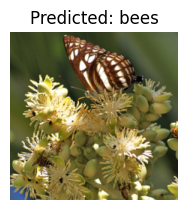

In [ ]:
visualize_model_predictions(
    model_conv,
    img_path='hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

part (b):

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms, models
import os

def extract_resnet18_features(dataloader):
    resnet18 = models.resnet18(pretrained=True)
    # Remove the final fully connected layer
    resnet18 = torch.nn.Sequential(*(list(resnet18.children())[:-1]))
    resnet18.eval()  # Set the model to evaluation mode
    
    features_list = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            features = resnet18(inputs)
            features_list.append(features.view(features.size(0), -1))
    
    return torch.cat(features_list, dim=0)

# Extract ResNet18 features for training images
train_features = extract_resnet18_features(dataloaders['train'])

# Check the shape of the extracted features
print(train_features.shape)


torch.Size([244, 512])


part(c):

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

# I have taken help from my friend Mrudul as i was stuck and getting some errors.

test_features =  extract_resnet18_features(dataloaders['val'])

train_labels = [label for _, label in image_datasets['train']]
test_labels = [label for _, label in image_datasets['val']]
# Define parameter grids for grid search
svm_param_grid = {'C': [0.1, 1, 10, 100],
                  'gamma': [0.001, 0.01, 0.1, 1]}

rf_param_grid = {'n_estimators': [50, 100, 200],
                 'max_depth': [1, 10, 20, 30]}

# Initialize classifiers
svm_classifier = SVC(kernel='rbf')
rf_classifier = RandomForestClassifier()

# Grid search for SVM
svm_grid_search = GridSearchCV(svm_classifier, svm_param_grid, cv=5)
svm_grid_search.fit(train_features.cpu().numpy(), train_labels)

# Grid search for Random Forest
rf_grid_search = GridSearchCV(rf_classifier, rf_param_grid, cv=5)
rf_grid_search.fit(train_features.cpu().numpy(), train_labels)

# Best parameters for SVM and Random Forest
best_svm_params = svm_grid_search.best_params_
best_rf_params = rf_grid_search.best_params_

# Initialize SVM and Random Forest classifiers with best parameters
svm_classifier_best = SVC(kernel='rbf', C=best_svm_params['C'], gamma=best_svm_params['gamma'])
rf_classifier_best = RandomForestClassifier(n_estimators=best_rf_params['n_estimators'], 
                                            max_depth=best_rf_params['max_depth'])

# Train the models on the entire training data
svm_classifier_best.fit(train_features.cpu().numpy(), train_labels)
rf_classifier_best.fit(train_features.cpu().numpy(), train_labels )

# Extract features for test images
test_features = extract_resnet18_features(dataloaders['val'])

# Predictions on test data
svm_test_predictions = svm_classifier_best.predict(test_features.cpu().numpy())
rf_test_predictions = rf_classifier_best.predict(test_features.cpu().numpy())

# True labels for test data
true_labels = test_labels

# Calculate accuracy and F1 score for SVM
svm_accuracy = accuracy_score(true_labels, svm_test_predictions)
svm_f1_score = f1_score(true_labels, svm_test_predictions, average='weighted')

# Calculate accuracy and F1 score for Random Forest
rf_accuracy = accuracy_score(true_labels, rf_test_predictions)
rf_f1_score = f1_score(true_labels, rf_test_predictions, average='weighted')

# Display results
print("SVM Results:")
print("Accuracy:", svm_accuracy)
print("F1 Score:", svm_f1_score)
print("\nRandom Forest Results:")
print("Accuracy:", rf_accuracy)
print("F1 Score:", rf_f1_score)
